In [ ]:
!pip install --upgrade pip -q
!pip install cupy-cuda12x -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.6 MB/s eta 0:00:00


In [ ]:

#@title --- Define a bounding box from all prototype vertices ---

all_x = []
all_y = []
for verts in vertices.values():
    for x, y in verts:
        all_x.append(x)
        all_y.append(y)

minx, maxx = min(all_x), max(all_x)
miny, maxy = min(all_y), max(all_y)

pad = 0.5  # margin around all points
minx -= pad
maxx += pad
miny -= pad
maxy += pad

# --- Create meshgrid ---
grid_size = 100  # adjust for resolution
xs = np.linspace(minx, maxx, grid_size)
ys = np.linspace(miny, maxy, grid_size)
X, Y = np.meshgrid(xs, ys)

# --- Flatten grid for GPU computation ---
points_to_test = np.vstack([X.ravel(), Y.ravel()]).T
points_to_test_gpu = cp.asarray(points_to_test, dtype=cp.float32)

# --- Run GPU Monte Carlo ---
membership_values = compute_membership_monte_carlo_gpu(points_to_test_gpu, n_samples=n_samples)

Generated 81 discrete configurations
Conceptual core computed: True
Computing membership values via GPU Monte Carlo...
Saved SVG: continuous_membership_voronoi.svg


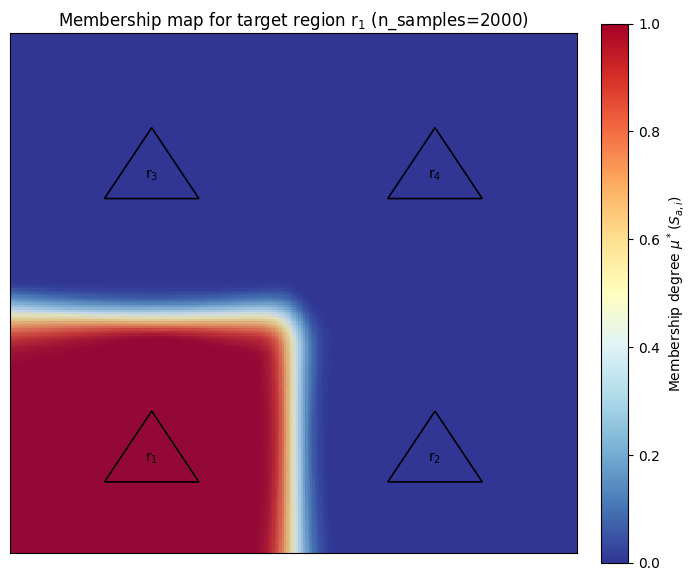

In [ ]:
#@title Continuous membership function

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import itertools
from matplotlib.patches import Polygon as MPLPolygon
import warnings
import cupy as cp
import random

warnings.filterwarnings('ignore')

# --------------------------
# Data (exact vertices given)
# --------------------------
vertices = {
    'r1': [(0.50000000, 0.25000000), (1.50000000, 0.25000000), (1.00000000, 1.00000000)],
    'r2': [(3.50000000, 0.25000000), (4.50000000, 0.25000000), (4.00000000, 1.00000000)],
    'r3': [(0.50000000, 3.25000000), (1.50000000, 3.25000000), (1.00000000, 4.00000000)],
    'r4': [(3.50000000, 3.25000000), (4.50000000, 3.25000000), (4.00000000, 4.00000000)],
}

prototypical_regions = {name: Polygon(verts) for name, verts in vertices.items()}

target_region = 'r1'
target_index = 0  # r1

# --------------------------
# Utility: discrete configs
# --------------------------
def generate_discrete_configurations():
    configurations = []
    for combo in itertools.product(*[vertices[f'r{i+1}'] for i in range(4)]):
        configurations.append(combo)
    return configurations

discrete_configs = generate_discrete_configurations()
print(f"Generated {len(discrete_configs)} discrete configurations")

# --------------------------
# Voronoi helper using fixed bbox (-1,-1,11,11)
# --------------------------
CLIP_BBOX = Polygon([(-1.0, -1.0), (11.0, -1.0), (11.0, 11.0), (-1.0, 11.0)])  # given bbox

def get_voronoi_cell(vor, point_idx, clip_poly):
    region_idx = vor.point_region[point_idx]
    region = vor.regions[region_idx]
    if -1 in region or len(region) == 0:
        return None
    vs = [vor.vertices[i] for i in region]
    if len(vs) < 3:
        return None
    try:
        cell = Polygon(vs)
        clipped = cell.intersection(clip_poly)
        return clipped if clipped.is_valid and not clipped.is_empty else None
    except:
        return None

def compute_conceptual_core(configs, target_idx, clip_poly=CLIP_BBOX):
    relevant_cells = []
    for config in configs:
        # buffer points to bound Voronoi
        buffer_points = [(-22.0, -22.0), (22.0, -22.0), (22.0, 22.0), (-22.0, 22.0)]
        extended_points = list(config) + buffer_points
        vor = Voronoi(extended_points)
        cell = get_voronoi_cell(vor, target_idx, clip_poly)
        if cell:
            relevant_cells.append(cell)
    if not relevant_cells:
        return None
    core = relevant_cells[0]
    for c in relevant_cells[1:]:
        core = core.intersection(c)
        if core.is_empty:
            break
    return core if core.is_valid and not core.is_empty else None

# compute conceptual_core if needed elsewhere; we will NOT plot it
conceptual_core = compute_conceptual_core(discrete_configs, target_index)
print(f"Conceptual core computed: {conceptual_core is not None}")

# --------------------------
# GPU sampling utilities
# --------------------------
vertices_gpu = {name: cp.array(verts, dtype=cp.float32) for name, verts in vertices.items()}

def sample_point_in_triangle_gpu(triangle_vertices, n_samples):
    v1, v2, v3 = triangle_vertices[0], triangle_vertices[1], triangle_vertices[2]
    r = cp.random.random((n_samples, 2), dtype=cp.float32)
    r1 = cp.where(r[:, 0] + r[:, 1] > 1, 1 - r[:, 0], r[:, 0])
    r2 = cp.where(r[:, 0] + r[:, 1] > 1, 1 - r[:, 1], r[:, 1])
    r1 = r1.reshape(-1, 1)
    r2 = r2.reshape(-1, 1)
    r3 = 1 - r1 - r2
    points = r1 * v1 + r2 * v2 + r3 * v3
    return points

def compute_membership_monte_carlo_gpu(points_grid, n_samples=2000):
    num_grid_points = points_grid.shape[0]
    config_samples = cp.empty((n_samples, 4, 2), dtype=cp.float32)
    for i in range(4):
        triangle_verts = vertices_gpu[f'r{i+1}']
        config_samples[:, i, :] = sample_point_in_triangle_gpu(triangle_verts, n_samples)
    points_grid_b = points_grid.reshape(num_grid_points, 1, 1, 2)
    config_samples_b = config_samples.reshape(1, n_samples, 4, 2)
    distances = cp.linalg.norm(points_grid_b - config_samples_b, axis=3)
    closest_indices = cp.argmin(distances, axis=2)
    favorable_counts = cp.sum(closest_indices == target_index, axis=1)
    membership = favorable_counts / n_samples
    return membership.get()

# --------------------------
# Grid / plotting parameters
# --------------------------
figsize = (np.float64(8.0), np.float64(7.0))
xlim = (-0.5, 5.5)   # width = 6.0
ylim = (-0.5, 5.0)   # height = 5.5
width = xlim[1] - xlim[0]   # 6.0
height = ylim[1] - ylim[0]  # 5.5
aspect = '1.0'

marker_size = 40
label_fontsize = 10
label_dx = 0.018 * width   # kept defined but not used for centered labels
label_dy = -0.022 * height # kept defined but not used for centered labels

cmap_name = 'RdYlBu_r'
alpha = 0.85
bbox_for_voronoi = (-1.0, -1.0, 11.0, 11.0)  # kept as value

cmap_m0_rgba = (0.192157, 0.211765, 0.584314, 1.0)
cmap_m75_rgba = (0.973472, 0.547405, 0.318108, 1.0)
composite_m75_rgb = (0.856275, 0.497059, 0.358039)

# --------------------------
# Create evaluation grid
# --------------------------
grid_size_x = 240
grid_size_y = int(grid_size_x * (height / width))
xs = np.linspace(xlim[0], xlim[1], grid_size_x)
ys = np.linspace(ylim[0], ylim[1], grid_size_y)
X, Y = np.meshgrid(xs, ys)

points_to_test = np.vstack([X.ravel(), Y.ravel()]).T
points_to_test_gpu = cp.asarray(points_to_test.astype(np.float32), dtype=cp.float32)

n_samples = 2000
print("Computing membership values via GPU Monte Carlo...")
membership_values_flat = compute_membership_monte_carlo_gpu(points_to_test_gpu, n_samples=n_samples)
membership_grid = membership_values_flat.reshape(X.shape)

# --------------------------
# Compose colors (alpha composition onto specified background)
# --------------------------
cmap = plt.get_cmap(cmap_name)
bg_rgb = np.array(cmap_m0_rgba[:3], dtype=np.float64)
alpha_f = float(alpha)

ny, nx = membership_grid.shape
flat_m = membership_grid.ravel()
fg_rgba = cmap(flat_m)[:, :3]
final_rgb_flat = alpha_f * fg_rgba + (1.0 - alpha_f) * bg_rgb[np.newaxis, :]
image_rgb = final_rgb_flat.reshape(ny, nx, 3)

# --------------------------
# Labels centered inside triangles
# --------------------------
fig, ax = plt.subplots(figsize=figsize)

ax.imshow(image_rgb, origin='lower',
          extent=(xlim[0], xlim[1], ylim[0], ylim[1]),
          aspect=aspect, interpolation='nearest')

# draw triangle outlines
for i in range(1, 5):
    key = f"r{i}"
    poly = prototypical_regions[key]
    coords = np.array(poly.exterior.coords)
    patch = MPLPolygon(coords, closed=True, fill=False, edgecolor='k', linewidth=1.2)
    ax.add_patch(patch)

# place the serif r_i labels at the triangle geometric center (average of vertices),
# centered horizontally and vertically (no dx/dy offset)
for i in range(1, 5):
    verts = np.array(vertices[f'r{i}'])
    tri_center_x = float(np.mean(verts[:, 0]))
    tri_center_y = float(np.mean(verts[:, 1]))
    label = r"$\mathrm{r}_{" + str(i) + "}$"
    ax.text(tri_center_x, tri_center_y,
            label, fontsize=label_fontsize, fontweight='bold',
            va='center', ha='center', zorder=6)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# colorbar (reference colormap)
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap=cmap)
sm.set_array(np.linspace(0, 1, 256))
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'Membership degree $\mu^*(S_{a,i})$')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(aspect)

i = target_index + 1
math_label = r"$\mathrm{r}_{" + str(i) + "}$"
ax.set_title("Membership map for target region " + math_label + f" (n_samples={n_samples})")

outname = 'continuous_membership_voronoi.svg'
fig.savefig(outname, bbox_inches='tight', format='svg')
print("Saved SVG:", outname)

plt.show()

Generated 81 discrete configurations
Conceptual core computed: True
Computing membership values via GPU Monte Carlo...
Saved SVG: continuous_membership_voronoi.svg


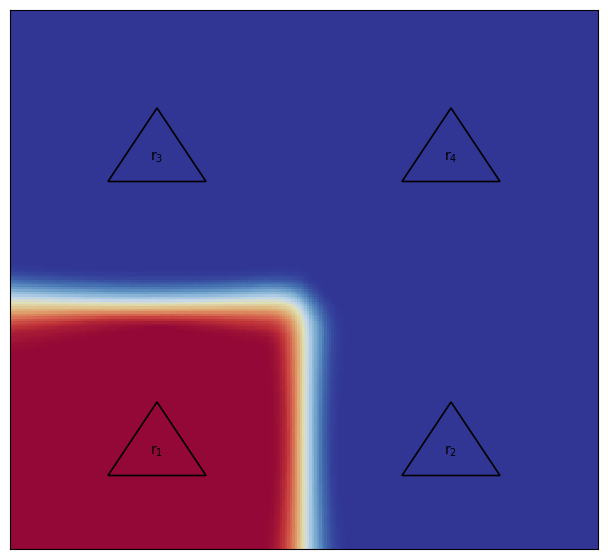

In [ ]:
#@title Continuous membership function

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import itertools
from matplotlib.patches import Polygon as MPLPolygon
import warnings
import cupy as cp
import random

warnings.filterwarnings('ignore')

# --------------------------
# Data (exact vertices given)
# --------------------------
vertices = {
    'r1': [(0.50000000, 0.25000000), (1.50000000, 0.25000000), (1.00000000, 1.00000000)],
    'r2': [(3.50000000, 0.25000000), (4.50000000, 0.25000000), (4.00000000, 1.00000000)],
    'r3': [(0.50000000, 3.25000000), (1.50000000, 3.25000000), (1.00000000, 4.00000000)],
    'r4': [(3.50000000, 3.25000000), (4.50000000, 3.25000000), (4.00000000, 4.00000000)],
}

prototypical_regions = {name: Polygon(verts) for name, verts in vertices.items()}

target_region = 'r1'
target_index = 0  # r1

# --------------------------
# Utility: discrete configs
# --------------------------
def generate_discrete_configurations():
    configurations = []
    for combo in itertools.product(*[vertices[f'r{i+1}'] for i in range(4)]):
        configurations.append(combo)
    return configurations

discrete_configs = generate_discrete_configurations()
print(f"Generated {len(discrete_configs)} discrete configurations")

# --------------------------
# Voronoi helper using fixed bbox (-1,-1,11,11)
# --------------------------
CLIP_BBOX = Polygon([(-1.0, -1.0), (11.0, -1.0), (11.0, 11.0), (-1.0, 11.0)])  # given bbox

def get_voronoi_cell(vor, point_idx, clip_poly):
    region_idx = vor.point_region[point_idx]
    region = vor.regions[region_idx]
    if -1 in region or len(region) == 0:
        return None
    vs = [vor.vertices[i] for i in region]
    if len(vs) < 3:
        return None
    try:
        cell = Polygon(vs)
        clipped = cell.intersection(clip_poly)
        return clipped if clipped.is_valid and not clipped.is_empty else None
    except:
        return None

def compute_conceptual_core(configs, target_idx, clip_poly=CLIP_BBOX):
    relevant_cells = []
    for config in configs:
        # buffer points to bound Voronoi
        buffer_points = [(-22.0, -22.0), (22.0, -22.0), (22.0, 22.0), (-22.0, 22.0)]
        extended_points = list(config) + buffer_points
        vor = Voronoi(extended_points)
        cell = get_voronoi_cell(vor, target_idx, clip_poly)
        if cell:
            relevant_cells.append(cell)
    if not relevant_cells:
        return None
    core = relevant_cells[0]
    for c in relevant_cells[1:]:
        core = core.intersection(c)
        if core.is_empty:
            break
    return core if core.is_valid and not core.is_empty else None

# compute conceptual_core if needed elsewhere; we will NOT plot it
conceptual_core = compute_conceptual_core(discrete_configs, target_index)
print(f"Conceptual core computed: {conceptual_core is not None}")

# --------------------------
# GPU sampling utilities
# --------------------------
vertices_gpu = {name: cp.array(verts, dtype=cp.float32) for name, verts in vertices.items()}

def sample_point_in_triangle_gpu(triangle_vertices, n_samples):
    v1, v2, v3 = triangle_vertices[0], triangle_vertices[1], triangle_vertices[2]
    r = cp.random.random((n_samples, 2), dtype=cp.float32)
    r1 = cp.where(r[:, 0] + r[:, 1] > 1, 1 - r[:, 0], r[:, 0])
    r2 = cp.where(r[:, 0] + r[:, 1] > 1, 1 - r[:, 1], r[:, 1])
    r1 = r1.reshape(-1, 1)
    r2 = r2.reshape(-1, 1)
    r3 = 1 - r1 - r2
    points = r1 * v1 + r2 * v2 + r3 * v3
    return points

def compute_membership_monte_carlo_gpu(points_grid, n_samples=2000):
    num_grid_points = points_grid.shape[0]
    config_samples = cp.empty((n_samples, 4, 2), dtype=cp.float32)
    for i in range(4):
        triangle_verts = vertices_gpu[f'r{i+1}']
        config_samples[:, i, :] = sample_point_in_triangle_gpu(triangle_verts, n_samples)
    points_grid_b = points_grid.reshape(num_grid_points, 1, 1, 2)
    config_samples_b = config_samples.reshape(1, n_samples, 4, 2)
    distances = cp.linalg.norm(points_grid_b - config_samples_b, axis=3)
    closest_indices = cp.argmin(distances, axis=2)
    favorable_counts = cp.sum(closest_indices == target_index, axis=1)
    membership = favorable_counts / n_samples
    return membership.get()

# --------------------------
# Grid / plotting parameters
# --------------------------
figsize = (np.float64(8.0), np.float64(7.0))
xlim = (-0.5, 5.5)   # width = 6.0
ylim = (-0.5, 5.0)   # height = 5.5
width = xlim[1] - xlim[0]   # 6.0
height = ylim[1] - ylim[0]  # 5.5
aspect = '1.0'

marker_size = 40
label_fontsize = 10
label_dx = 0.018 * width   # kept defined but not used for centered labels
label_dy = -0.022 * height # kept defined but not used for centered labels

cmap_name = 'RdYlBu_r'
alpha = 0.85
bbox_for_voronoi = (-1.0, -1.0, 11.0, 11.0)  # kept as value

cmap_m0_rgba = (0.192157, 0.211765, 0.584314, 1.0)
cmap_m75_rgba = (0.973472, 0.547405, 0.318108, 1.0)
composite_m75_rgb = (0.856275, 0.497059, 0.358039)

# --------------------------
# Create evaluation grid
# --------------------------
grid_size_x = 240
grid_size_y = int(grid_size_x * (height / width))
xs = np.linspace(xlim[0], xlim[1], grid_size_x)
ys = np.linspace(ylim[0], ylim[1], grid_size_y)
X, Y = np.meshgrid(xs, ys)

points_to_test = np.vstack([X.ravel(), Y.ravel()]).T
points_to_test_gpu = cp.asarray(points_to_test.astype(np.float32), dtype=cp.float32)

n_samples = 2000
print("Computing membership values via GPU Monte Carlo...")
membership_values_flat = compute_membership_monte_carlo_gpu(points_to_test_gpu, n_samples=n_samples)
membership_grid = membership_values_flat.reshape(X.shape)

# --------------------------
# Compose colors (alpha composition onto specified background)
# --------------------------
cmap = plt.get_cmap(cmap_name)
bg_rgb = np.array(cmap_m0_rgba[:3], dtype=np.float64)
alpha_f = float(alpha)

ny, nx = membership_grid.shape
flat_m = membership_grid.ravel()
fg_rgba = cmap(flat_m)[:, :3]
final_rgb_flat = alpha_f * fg_rgba + (1.0 - alpha_f) * bg_rgb[np.newaxis, :]
image_rgb = final_rgb_flat.reshape(ny, nx, 3)

# --------------------------
# Labels centered inside triangles
# --------------------------
fig, ax = plt.subplots(figsize=figsize)

ax.imshow(image_rgb, origin='lower',
          extent=(xlim[0], xlim[1], ylim[0], ylim[1]),
          aspect=aspect, interpolation='nearest')

# draw triangle outlines
for i in range(1, 5):
    key = f"r{i}"
    poly = prototypical_regions[key]
    coords = np.array(poly.exterior.coords)
    patch = MPLPolygon(coords, closed=True, fill=False, edgecolor='k', linewidth=1.2)
    ax.add_patch(patch)

# place the serif r_i labels at the triangle geometric center (average of vertices),
# centered horizontally and vertically (no dx/dy offset)
for i in range(1, 5):
    verts = np.array(vertices[f'r{i}'])
    tri_center_x = float(np.mean(verts[:, 0]))
    tri_center_y = float(np.mean(verts[:, 1]))
    label = r"$\mathrm{r}_{" + str(i) + "}$"
    ax.text(tri_center_x, tri_center_y,
            label, fontsize=label_fontsize, fontweight='bold',
            va='center', ha='center', zorder=6)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(aspect)

i = target_index + 1
math_label = r"$\mathrm{r}_{" + str(i) + "}$"

outname = 'continuous_membership_voronoi.svg'
fig.savefig(outname, bbox_inches='tight', format='svg')
print("Saved SVG:", outname)

plt.show()

Generated 81 discrete configurations
Conceptual core computed: True
Computing membership values via GPU Monte Carlo...
Saved SVG: membership_map_r_i.svg


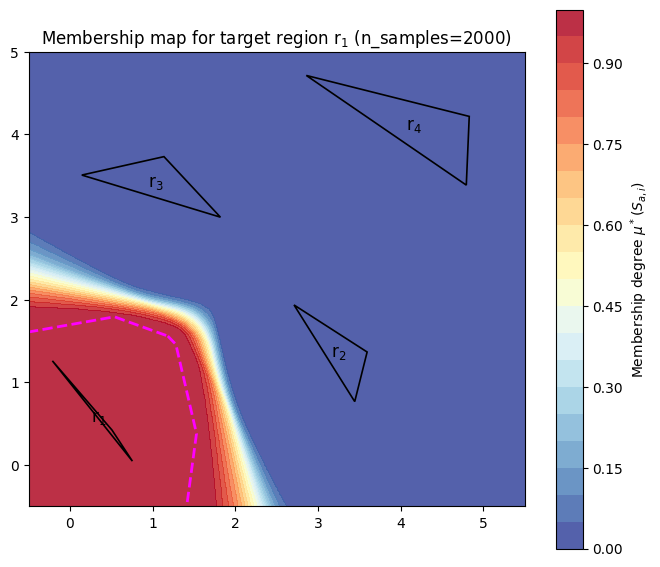

In [ ]:
#@title With random generation of prototypical regions
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
import itertools
from matplotlib.patches import Polygon as MPLPolygon
from matplotlib.collections import LineCollection
import warnings
import cupy as cp
import random

warnings.filterwarnings('ignore')

# Step 1: Environment Setup and Data Definition

# Define the 12 vertices for the 4 triangular prototypical regions
TRIANGLE_SPREAD = 1.1

def random_triangle(center_x, center_y, spread=1):
    """Generates the 3 vertices of a random triangle around a center point."""
    return [
        (round(center_x + random.uniform(-spread, spread), 8), round(center_y + random.uniform(-spread, spread), 8)),
        (round(center_x + random.uniform(-spread, spread), 8), round(center_y + random.uniform(-spread, spread), 8)),
        (round(center_x + random.uniform(-spread, spread), 8), round(center_y + random.uniform(-spread, spread), 8)),
    ]

# Define the center points for four triangles in different quadrants
centers = [
    (random.uniform(0, 1), random.uniform(0, 1)),
    (random.uniform(3, 4), random.uniform(0, 1)),
    (random.uniform(0, 1), random.uniform(3, 4)),
    (random.uniform(3, 4), random.uniform(3, 4)),
]

# Generate the dictionary of triangles
vertices = {
    f'r{i+1}': random_triangle(cx, cy, spread=TRIANGLE_SPREAD)
    for i, (cx, cy) in enumerate(centers)
}


# Create Shapely Polygon objects for each prototypical region
prototypical_regions = {
    name: Polygon(verts) for name, verts in vertices.items()
}

# Select target region (e.g., r1)
target_region = 'r1'
target_index = 0  # Index for r1

# Step 2: Discrete Framework Analysis

def generate_discrete_configurations():
    """Generate all 81 discrete configurations from vertex combinations."""
    configurations = []
    for combo in itertools.product(*[vertices[f'r{i+1}'] for i in range(4)]):
        configurations.append(combo)
    return configurations

def compute_voronoi_edges(points, bbox_size=10):
    """Compute Voronoi diagram and return edges clipped to bbox."""
    # Add buffer points far outside to bound the diagram
    buffer_points = [
        (-bbox_size, -bbox_size), (bbox_size, -bbox_size),
        (bbox_size, bbox_size), (-bbox_size, bbox_size)
    ]
    extended_points = list(points) + buffer_points

    vor = Voronoi(extended_points)
    edges = []

    for simplex in vor.ridge_vertices:
        if -1 not in simplex:
            p1 = vor.vertices[simplex[0]]
            p2 = vor.vertices[simplex[1]]
            edges.append((p1, p2))

    return edges

# Generate all discrete configurations
discrete_configs = generate_discrete_configurations()
print(f"Generated {len(discrete_configs)} discrete configurations")

# Compute all Voronoi edges
all_voronoi_edges = []
for config in discrete_configs:
    edges = compute_voronoi_edges(config)
    all_voronoi_edges.extend(edges)

# Step 3: Calculate the Conceptual Core

def get_voronoi_cell(vor, point_idx, bbox):
    """Extract the Voronoi cell for a given point as a Polygon."""
    region_idx = vor.point_region[point_idx]
    region = vor.regions[region_idx]

    if -1 in region or len(region) == 0:
        return None

    vertices = [vor.vertices[i] for i in region]

    # Check if vertices form a valid polygon
    if len(vertices) < 3:
        return None

    try:
        cell = Polygon(vertices)
        # Clip to bounding box
        clipped = cell.intersection(bbox)
        return clipped if clipped.is_valid else None
    except:
        return None

def compute_conceptual_core(configs, target_idx, bbox_size=10):
    """Compute the intersection of all relevant Voronoi cells."""
    bbox = Polygon([
        (-bbox_size, -bbox_size), (bbox_size, -bbox_size),
        (bbox_size, bbox_size), (-bbox_size, bbox_size)
    ])

    relevant_cells = []

    for config in configs:
        # Add buffer points
        buffer_points = [
            (-bbox_size*2, -bbox_size*2), (bbox_size*2, -bbox_size*2),
            (bbox_size*2, bbox_size*2), (-bbox_size*2, bbox_size*2)
        ]
        extended_points = list(config) + buffer_points

        vor = Voronoi(extended_points)
        cell = get_voronoi_cell(vor, target_idx, bbox)

        if cell and cell.is_valid and not cell.is_empty:
            relevant_cells.append(cell)

    # Compute intersection
    if relevant_cells:
        core = relevant_cells[0]
        for cell in relevant_cells[1:]:
            core = core.intersection(cell)
            if core.is_empty:
                break
        return core if core.is_valid and not core.is_empty else None

    return None

# Calculate conceptual core
conceptual_core = compute_conceptual_core(discrete_configs, target_index)
print(f"Conceptual core computed: {conceptual_core is not None}")

# Step 4: Monte Carlo Simulation for Continuous Membership Function

vertices_gpu = {
    name: cp.array(verts, dtype=cp.float32) for name, verts in vertices.items()
}

def sample_point_in_triangle_gpu(triangle_vertices, n_samples):
    """Generates n_samples random points inside a triangle on the GPU."""
    v1, v2, v3 = triangle_vertices[0], triangle_vertices[1], triangle_vertices[2]

    # Generate random barycentric coordinates on the GPU
    r = cp.random.random((n_samples, 2), dtype=cp.float32)

    # Condition to keep points within the triangle bounds
    r1 = cp.where(r[:, 0] + r[:, 1] > 1, 1 - r[:, 0], r[:, 0])
    r2 = cp.where(r[:, 0] + r[:, 1] > 1, 1 - r[:, 1], r[:, 1])

    # Reshape for broadcasting
    r1 = r1.reshape(-1, 1)
    r2 = r2.reshape(-1, 1)
    r3 = 1 - r1 - r2

    # Convert to Cartesian coordinates using broadcasted multiplication
    points = r1 * v1 + r2 * v2 + r3 * v3
    return points

def compute_membership_monte_carlo_gpu(points_grid, n_samples=2000):
    """
    Computes μ*(Sₐ,ᵢ) for an entire grid of points at once on the GPU.
    """
    num_grid_points = points_grid.shape[0]

    # 1. Generate all random configurations at once on the GPU
    # Shape: (n_samples, 4, 2) -> 2000 samples for each of the 4 regions
    config_samples = cp.empty((n_samples, 4, 2), dtype=cp.float32)
    for i in range(4):
        triangle_verts = vertices_gpu[f'r{i+1}']
        config_samples[:, i, :] = sample_point_in_triangle_gpu(triangle_verts, n_samples)

    # 2. Prepare grid points for broadcasting
    # Reshape points_grid from (num_grid_points, 2) to (num_grid_points, 1, 1, 2)
    # Reshape config_samples from (n_samples, 4, 2) to (1, n_samples, 4, 2)
    # This allows NumPy/CuPy to broadcast and compare every grid point against every sample config
    points_grid_b = points_grid.reshape(num_grid_points, 1, 1, 2)
    config_samples_b = config_samples.reshape(1, n_samples, 4, 2)

    # 3. Compute all distances in a single, massive operation
    # The result `distances` will have shape: (num_grid_points, n_samples, 4)
    distances = cp.linalg.norm(points_grid_b - config_samples_b, axis=3)

    # 4. Find which region was closest for each sample
    # Result `closest_indices` has shape: (num_grid_points, n_samples)
    closest_indices = cp.argmin(distances, axis=2)

    # 5. For each grid point, count how many times the target_index was the closest
    # `cp.sum` over axis=1 (the samples axis)
    favorable_counts = cp.sum(closest_indices == target_index, axis=1)

    # 6. Calculate membership and return to CPU
    membership = favorable_counts / n_samples
    return membership.get() # .get() moves the array from GPU memory to CPU memory

# --- Main execution part for the GPU version ---
print("Computing membership values via GPU Monte Carlo...")
n_samples = 2000

# Flatten the grid and move it to the GPU
points_to_test = np.vstack([X.ravel(), Y.ravel()]).T
points_to_test_gpu = cp.asarray(points_to_test, dtype=cp.float32)

# Run the entire computation
membership_values_flat = compute_membership_monte_carlo_gpu(points_to_test_gpu, n_samples)

# Reshape the result back to the grid shape for plotting
membership_values = membership_values_flat.reshape(X.shape)

# Step 5: Final Visualization

# Ensure membership_values is a CPU numpy array (if it's a CuPy array, .get() it)
if hasattr(membership_values, "get"):
    membership_values = membership_values.get()

# reshape to 2D grid (must match X.shape)
if membership_values.size != X.size:
    raise ValueError(f"membership_values length {membership_values.size} != grid points {X.size}")

membership_grid = membership_values.reshape(X.shape)

fig, ax = plt.subplots(figsize=(8, 7))

# Contourf heatmap
im = ax.contourf(X, Y, membership_grid, levels=20, cmap='RdYlBu_r', alpha=0.85)
cbar = plt.colorbar(im, ax=ax, label=r'Membership degree $\mu^*(S_{a,i})$')

# Overlay prototypical triangles and label them as serif r_i (mathtext \mathrm for upright/serif)
for i in range(1, 5):
    key = f"r{i}"
    poly = prototypical_regions[key]
    coords = np.array(poly.exterior.coords)
    patch = MPLPolygon(coords, closed=True, fill=False, edgecolor='k', linewidth=1.2)
    ax.add_patch(patch)

    # label: use \mathrm to get upright (serif-like) r and put subscript index
    label = rf'$\mathrm{{r}}_{{{i}}}$'   # produces \mathrm{r}_{i}
    cx, cy = poly.centroid.x, poly.centroid.y
    ax.text(cx, cy, label, ha='center', va='center', fontsize=12, fontweight='bold')

# Conceptual core outline (if present)
if conceptual_core is not None:
    try:
        core_coords = np.array(conceptual_core.exterior.coords)
        patch_core = MPLPolygon(core_coords, closed=True, fill=False,
                                edgecolor='magenta', linewidth=2, linestyle='--')
        ax.add_patch(patch_core)
    except Exception:
        pass

ax.set_aspect('equal')
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
i = target_index + 1
ax.set_title("Membership map for target region " + r"$\mathrm{r}_{" + str(i) + "}$" + f" (n_samples={n_samples})")

# Save as SVG
svg_filename = "membership_map_r_i.svg"
fig.savefig(svg_filename, format="svg", bbox_inches="tight")
print(f"Saved SVG: {svg_filename}")

plt.show()

In [ ]:
# Define the 12 vertices for the 4 triangular prototypical regions
vertices = {
    'r1': [(0.50000000, 0.25000000), (1.50000000, 0.25000000), (1.00000000, 1.00000000)],
    'r2': [(3.50000000, 0.25000000), (4.50000000, 0.25000000), (4.00000000, 1.00000000)],
    'r3': [(0.50000000, 3.25000000), (1.50000000, 3.25000000), (1.00000000, 4.00000000)],
    'r4': [(3.50000000, 3.25000000), (4.50000000, 3.25000000), (4.00000000, 4.00000000)],
}

In [ ]:
import random
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def generate_random_triangles(num_triangles=3, canvas_size=(100, 100), min_center_dist=30, cluster_radius=5):
    width, height = canvas_size
    centers = []

    # 1. Generate centroids that are "far apart" from each other
    while len(centers) < num_triangles:
        # Pick a random candidate for a new center
        candidate_center = (random.uniform(cluster_radius, width - cluster_radius),
                            random.uniform(cluster_radius, height - cluster_radius))

        # Check if it's far enough from all existing centers
        is_far_enough = True
        for existing_center in centers:
            dist = math.hypot(candidate_center[0] - existing_center[0],
                             candidate_center[1] - existing_center[1])
            if dist < min_center_dist:
                is_far_enough = False
                break

        if is_far_enough:
            centers.append(candidate_center)

    # 2. Generate triangle vertices in a "tight cluster" around each centroid
    triangles = {}
    for i, center in enumerate(centers):
        vertices = []
        for _ in range(3):  # A triangle has 3 vertices
            # Generate a random point within a circle of 'cluster_radius' around the center
            angle = random.uniform(0, 2 * math.pi)
            radius = random.uniform(0, cluster_radius)

            offset_x = radius * math.cos(angle)
            offset_y = radius * math.sin(angle)

            vertex_x = center[0] + offset_x
            vertex_y = center[1] + offset_y

            vertices.append((vertex_x, vertex_y))

        triangles[f't{i+1}'] = vertices

    return triangles

def visualize_triangles(triangles_dict, canvas_size=(100, 100)):
    """Plots the generated triangles using Matplotlib."""
    fig, ax = plt.subplots()

    # Use a color cycle for different triangles
    colors = plt.cm.viridis([i/len(triangles_dict) for i in range(len(triangles_dict))])

    for i, (name, vertices) in enumerate(triangles_dict.items()):
        # Draw the triangle
        poly = Polygon(vertices, closed=True, facecolor=colors[i], alpha=0.6, edgecolor='k')
        ax.add_patch(poly)

        # Plot the vertices as points
        x_coords, y_coords = zip(*vertices)
        ax.scatter(x_coords, y_coords, c='black', s=20, zorder=5)

    ax.set_xlim(0, canvas_size[0])
    ax.set_ylim(0, canvas_size[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"{len(triangles_dict)} Random Triangles")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


generated_vertices = generate_random_triangles(
    num_triangles=3,
    canvas_size=(100, 100), # Triangles will be in a 100x100 area
    min_center_dist=40,    # Their centers must be at least 40 units apart
    cluster_radius=8       # Vertices will be within 8 units of their center
)

Created 4 regions with 3 prototypes each
Generated 81 configurations
Creating atomic cells...
Created 272 atomic cells
Calculating membership degrees...
Creating visualization...


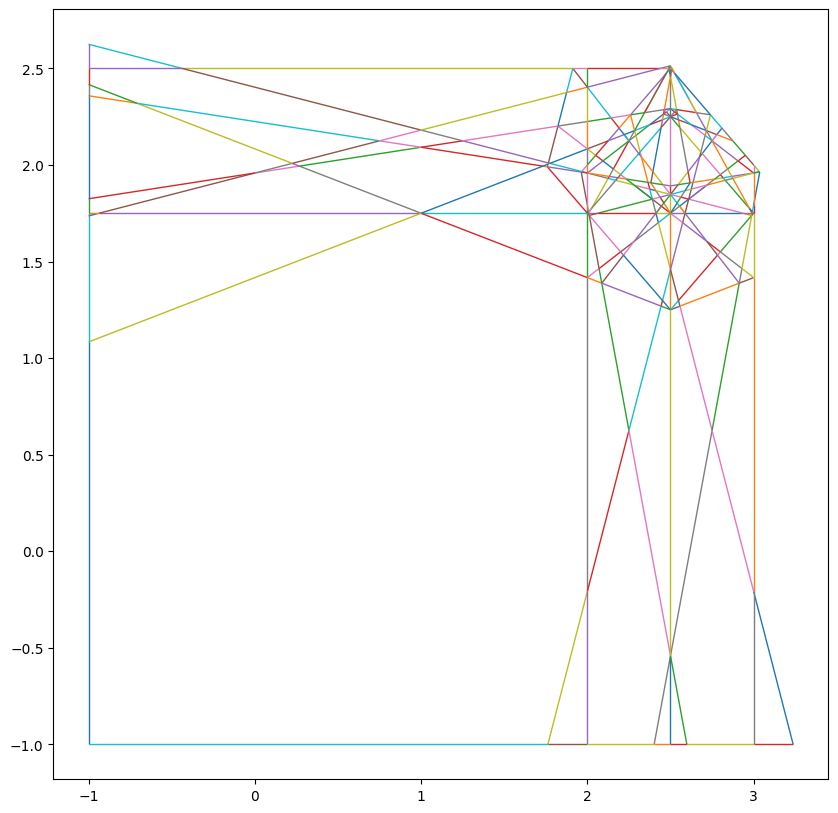

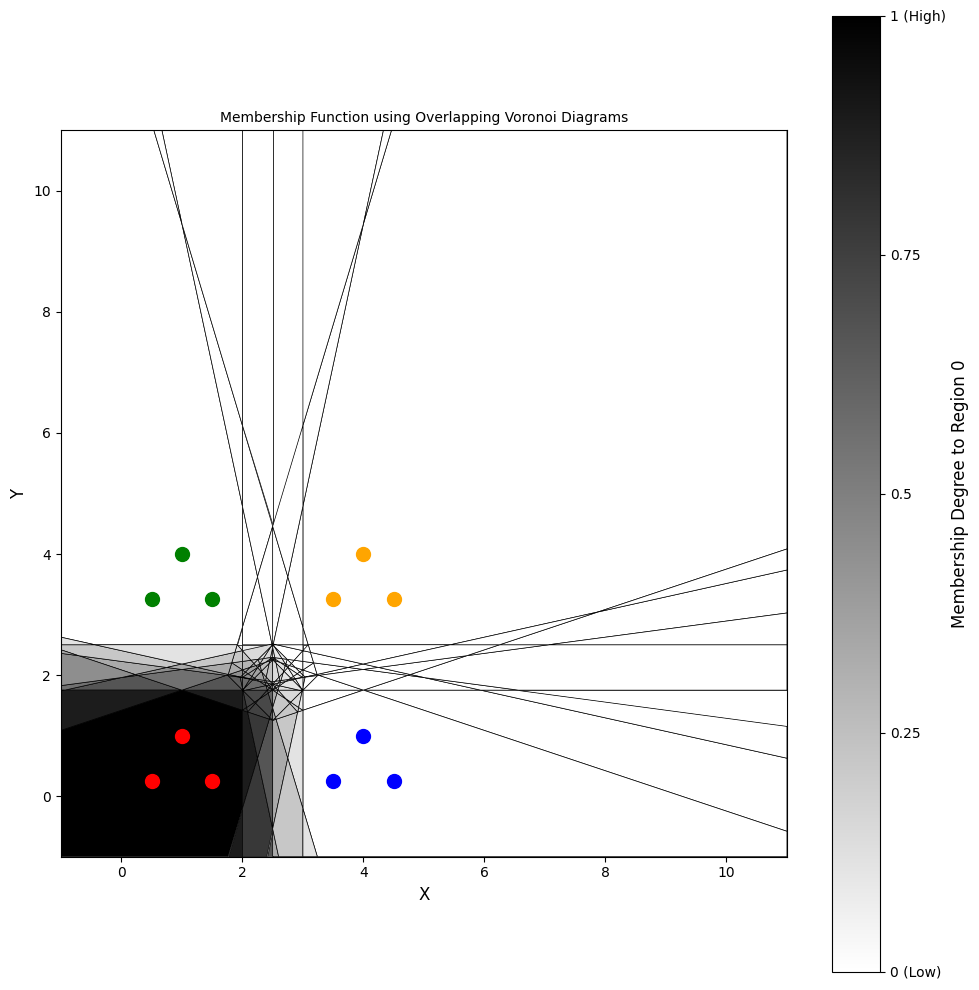


Unique membership degrees: [0.0, 0.024691358024691357, 0.037037037037037035, 0.04938271604938271, 0.07407407407407407, 0.09876543209876543, 0.1111111111111111, 0.12345679012345678, 0.14814814814814814, 0.1728395061728395, 0.18518518518518517, 0.19753086419753085, 0.2222222222222222, 0.24691358024691357, 0.25925925925925924, 0.2716049382716049, 0.2962962962962963, 0.32098765432098764, 0.3333333333333333, 0.345679012345679, 0.37037037037037035, 0.3950617283950617, 0.4444444444444444, 0.4567901234567901, 0.4691358024691358, 0.5061728395061729, 0.5555555555555556, 0.5802469135802469, 0.6049382716049383, 0.6296296296296297, 0.6666666666666666, 0.7160493827160493, 0.7407407407407407, 0.7654320987654321, 0.7777777777777778, 0.8148148148148148, 0.8888888888888888, 1.0]
Number of unique membership values: 38


In [ ]:
#@title An experiment

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, box, LineString, MultiLineString
from shapely.ops import unary_union, polygonize
import itertools
from collections import defaultdict
from shapely.geometry import LineString

PROTOTYPES = {
    'r1': [(0.50000000, 0.25000000), (1.50000000, 0.25000000), (1.00000000, 1.00000000)],
    'r2': [(3.50000000, 0.25000000), (4.50000000, 0.25000000), (4.00000000, 1.00000000)],
    'r3': [(0.50000000, 3.25000000), (1.50000000, 3.25000000), (1.00000000, 4.00000000)],
    'r4': [(3.50000000, 3.25000000), (4.50000000, 3.25000000), (4.00000000, 4.00000000)],
}


# Generating Configurations
def generate_configurations(prototypes):
    """Generate all possible prototype configurations"""
    # prototypes is expected to be a dict mapping region->list of prototype coords
    configurations = list(itertools.product(*prototypes.values()))
    return configurations


# Constructing Individual Voronoi Diagrams
def voronoi_finite_polygons_2d(vor, radius=None):
    """Convert infinite Voronoi regions to finite polygons"""
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # Finite region
            new_regions.append(vertices)
            continue

        # Reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # Sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


# Constructing the Collated Voronoi Diagram
def create_atomic_cells(configurations, prototypes, bbox):
    """Create atomic cells by overlaying all Voronoi diagrams"""
    # Collect all edges from all Voronoi diagrams
    all_lines = []

    for config in configurations:
        points = np.array(config)
        vor = Voronoi(points)

        # Extract finite edges
        for simplex in vor.ridge_vertices:
            if all(i >= 0 for i in simplex):
                i, j = simplex
                p1 = vor.vertices[i]
                p2 = vor.vertices[j]
                # Create LineString instead of Polygon boundary
                line = LineString([p1, p2])
                # Clip to bbox
                clipped = line.intersection(bbox)
                if not clipped.is_empty:
                    all_lines.append(clipped)

        # Handle infinite edges
        center = vor.points.mean(axis=0)
        for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
            simplex = np.asarray(simplex)
            if np.any(simplex < 0):
                finite_inds = simplex[simplex >= 0]
                if len(finite_inds) == 0:
                    continue
                i = finite_inds[0]  # finite end Voronoi vertex

                t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
                t /= np.linalg.norm(t)
                n = np.array([-t[1], t[0]])  # normal

                midpoint = vor.points[pointidx].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n

                # Extend the edge to bbox boundary
                far_point = vor.vertices[i] + direction * 20
                line = LineString([vor.vertices[i], far_point])
                clipped = line.intersection(bbox)
                if not clipped.is_empty:
                    # clipped might be LineString or MultiLineString
                    if isinstance(clipped, (LineString,)):
                        all_lines.append(clipped)
                    else:
                        # add each geometry in the collection
                        try:
                            for geom in clipped.geoms:
                                all_lines.append(geom)
                        except Exception:
                            all_lines.append(clipped)

    # Add bbox edges as separate line segments
    coords = list(bbox.exterior.coords)
    for i in range(len(coords) - 1):
        all_lines.append(LineString([coords[i], coords[i + 1]]))

    # Create union of all lines and polygonize
    if all_lines:
        merged = unary_union(all_lines)
        # Ensure we have a collection of lines
        if hasattr(merged, 'geoms'):
            atomic_polygons = list(polygonize(merged))
        else:
            atomic_polygons = list(polygonize([merged]))
    else:
        atomic_polygons = [bbox]

    # Filter out invalid or empty polygons
    valid_polygons = []
    for poly in atomic_polygons:
        if poly.is_valid and not poly.is_empty and poly.area > 1e-10:
            valid_polygons.append(poly)

    return valid_polygons


# Calculate Membership Degrees
def calculate_membership_degrees(atomic_cells, configurations, prototypes, target_region=0):
    """Calculate membership degree for each atomic cell"""
    membership_degrees = {}

    for cell_idx, cell in enumerate(atomic_cells):
        # Get representative point
        representative = cell.centroid
        if not cell.contains(representative):
            representative = cell.representative_point()

        # Count configurations where representative belongs to target region
        count = 0
        for config_idx, config in enumerate(configurations):
            # Find which prototype in this configuration is closest
            points = np.array(config)
            distances = np.linalg.norm(points - np.array([representative.x, representative.y]), axis=1)
            closest_idx = np.argmin(distances)

            # prototype_region is the index in the configuration tuple
            prototype_region = closest_idx

            if prototype_region == target_region:
                count += 1

        membership_degree = count / len(configurations)
        membership_degrees[cell_idx] = membership_degree

    return membership_degrees

#########
def extract_edges_from_polygons(polygons, round_digits=9):
    """
    Return a dict mapping a direction-invariant key -> {'line': LineString, 'polys': [poly_idx, ...]}
    Each polygon exterior edge becomes a single key (so reversed segments map to same key).
    Coordinates are rounded to avoid tiny floating differences.
    """
    edges = {}
    for idx, poly in enumerate(polygons):
        if not hasattr(poly, 'exterior'):
            continue
        coords = list(poly.exterior.coords)
        for i in range(len(coords) - 1):
            a = (round(coords[i][0], round_digits), round(coords[i][1], round_digits))
            b = (round(coords[i + 1][0], round_digits), round(coords[i + 1][1], round_digits))
            # make key direction-invariant
            key1 = tuple(a + b)
            key2 = tuple(b + a)
            key = key1 if key1 <= key2 else key2
            if key not in edges:
                edges[key] = {'line': LineString([a, b]), 'polys': []}
            if idx not in edges[key]['polys']:
                edges[key]['polys'].append(idx)
    return edges


def prune_edges_by_membership(edges_map, membership_degrees, keep_if_equal=True):
    """
    Given the edges_map (from extract_edges_from_polygons) and membership_degrees dict
    (mapping polygon idx -> membership value), return a list of LineString to KEEP.
    keep_if_equal: if True, keeps edge when any adjacent polygon has membership > 0
                   (strictly positive). If you ever want to treat very small values as zero,
                   threshold externally before calling.
    """
    kept = []
    for key, entry in edges_map.items():
        poly_idxs = entry['polys']
        # If any adjacent polygon has membership > 0 => keep the segment
        keep = False
        for pi in poly_idxs:
            val = membership_degrees.get(pi, 0.0)
            if keep_if_equal:
                if val > 0.0:
                    keep = True
                    break
            else:
                # alternative: keep if val >= 0.0 (not useful here but provided)
                if val >= 0.0:
                    keep = True
                    break
        if keep:
            kept.append(entry['line'])
    return kept


def polygonize_from_lines(lines):
    """
    Given an iterable of LineString, union them and polygonize.
    Returns list of Polygons.
    """
    if not lines:
        return []
    merged = unary_union(lines)
    # polygonize accepts a geometry or sequence of geometries
    polys = list(polygonize(merged))
    return polys
#########
# Visualization
def visualize_membership_function(atomic_cells, membership_degrees, prototypes):
    """Visualize the membership function"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Create grayscale colormap (reversed so high values are dark)
    cmap = plt.cm.gray_r  # reversed gray: 0=white, 1=black
    norm = plt.Normalize(vmin=0, vmax=1)

    # Plot atomic cells
    for cell_idx, cell in enumerate(atomic_cells):
        if cell_idx in membership_degrees:
            # Convert membership degree to grayscale
            gray_value = membership_degrees[cell_idx]
            color = cmap(norm(gray_value))

            if hasattr(cell, 'exterior'):
                x, y = cell.exterior.xy
                ax.fill(x, y, color=color, edgecolor='black', linewidth=0.5, alpha=1.0)

    # Plot prototype points
    colors = ['red', 'blue', 'green', 'orange']

    # prototypes is a dict, iterate items to get region name and prototypes list
    for i, (region_name, region_prototypes) in enumerate(prototypes.items()):
        for j, proto in enumerate(region_prototypes):
            ax.scatter(proto[0], proto[1],
                       color=colors[i % len(colors)], s=100,
                       marker='o',
                       label=(region_name if j == 0 else None),
                       zorder=5)

    # Add colorbar with grayscale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Membership Degree to Region 0', fontsize=12)

    # Add custom tick labels to clarify the scale
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(['0 (Low)', '0.25', '0.5', '0.75', '1 (High)'])

    # Set plot properties
    ax.set_xlim(-1, 11)
    ax.set_ylim(-1, 11)
    ax.set_aspect('equal')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title('Membership Function using Overlapping Voronoi Diagrams', fontsize=10)

    plt.tight_layout()
    plt.show()


# Main execution
def main():
    # Use the top-level PROTOTYPES variable (don't shadow it)
    prototypes = PROTOTYPES
    num_regions = len(prototypes)
    prototypes_per_region = len(next(iter(prototypes.values())))
    print(f"Created {num_regions} regions with {prototypes_per_region} prototypes each")

    # Step 2: Generate configurations
    configurations = generate_configurations(prototypes)
    print(f"Generated {len(configurations)} configurations")

    # Define bounding box
    bbox = box(-1, -1, 11, 11)

    # Step 4: Create atomic cells
    print("Creating atomic cells...")
    atomic_cells = create_atomic_cells(configurations, prototypes, bbox)
    print(f"Created {len(atomic_cells)} atomic cells")

    # Step 5: Calculate membership degrees
    print("Calculating membership degrees...")
    target_region = 0  # Choose region r_0 as target
    membership_degrees = calculate_membership_degrees(atomic_cells, configurations, prototypes, target_region)


    edges_map = extract_edges_from_polygons(atomic_cells, round_digits=9)

    # 2) prune segments whose adjacent polygons are all empty (membership == 0)
    kept_segments = prune_edges_by_membership(edges_map, membership_degrees)

    # 3a) Option A: if you only want to draw the pruned segment set, overlay them:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # ... (draw filled atomic cells as before if you want) ...
    for seg in kept_segments:
        xs, ys = seg.xy
        ax.plot(xs, ys, linewidth=1.0, solid_capstyle='butt')

    # 3b) Option B (optional): polygonize using kept segments and recompute membership
    # (this will merge polygons that are separated only by removed segments)
    new_polygons = polygonize_from_lines(kept_segments)

    # Step 6: Visualize
    print("Creating visualization...")
    visualize_membership_function(atomic_cells, membership_degrees, prototypes)

    # Print statistics
    unique_degrees = sorted(set(membership_degrees.values()))
    print(f"\nUnique membership degrees: {unique_degrees}")
    print(f"Number of unique membership values: {len(unique_degrees)}")


if __name__ == "__main__":
    main()


In [ ]:
#@title make each prototypical region twice as smaller

import numpy as np

# --- Données d'entrée ---
original_vertices = {
    'r1': [(0.29289322, 0.14644661), (1.70710678, 0.14644661), (1.0, 1.20710678)],
    'r2': [(3.29289322, 0.14644661), (4.70710678, 0.14644661), (4.0, 1.20710678)],
    'r3': [(0.29289322, 3.14644661), (1.70710678, 3.14644661), (1.0, 4.20710678)],
    'r4': [(3.29289322, 3.14644661), (4.70710678, 3.14644661), (4.0, 4.20710678)],
}

# --- Calcul ---

# Le facteur de réduction pour les longueurs afin de diviser la surface par 2.
# k^2 = 1/2  =>  k = 1/sqrt(2)
scaling_factor = 1 / np.sqrt(2)

# Dictionnaire pour stocker les nouveaux sommets
scaled_vertices = {}

print("Calcul des nouvelles coordonnées...\n")

# Itération sur chaque région prototypique
for name, verts in original_vertices.items():
    # Conversion des points en tableau NumPy pour faciliter les calculs vectoriels
    points_array = np.array(verts)

    # 1. Calculer le barycentre (moyenne des coordonnées des points)
    centroid = np.mean(points_array, axis=0)

    # Liste pour stocker les nouveaux sommets de la région en cours
    new_region_verts = []

    # 2. Appliquer la transformation à chaque sommet
    for point in points_array:
        # Vecteur allant du barycentre au point
        vector_to_point = point - centroid

        # Réduire ce vecteur par le facteur de réduction
        scaled_vector = vector_to_point * scaling_factor

        # Le nouveau point est le barycentre + le vecteur réduit
        new_point = centroid + scaled_vector

        # Ajouter le nouveau point (reconverti en tuple) à la liste
        new_region_verts.append(tuple(new_point))

    # Stocker le résultat dans le nouveau dictionnaire
    scaled_vertices[name] = new_region_verts

    print(f"Région '{name}':")
    print(f"  - Barycentre: {np.round(centroid, 3)}")
    print(f"  - Nouveaux sommets: {[(round(p[0], 3), round(p[1], 3)) for p in new_region_verts]}")
    print("-" * 30)

# --- Résultat Final ---
# Affiche le dictionnaire final que vous pouvez copier-coller dans votre script principal.
print("\nVoici le dictionnaire final 'scaled_vertices' à utiliser :\n")
print("vertices = {")
for name, verts in scaled_vertices.items():
    # Formattage propre pour le copier-coller
    formatted_verts = ", ".join([f"({v[0]:.8f}, {v[1]:.8f})" for v in verts])
    print(f"    '{name}': [{formatted_verts}],")
print("}")

Calcul des nouvelles coordonnées...

Région 'r1':
  - Barycentre: [1.  0.5]
  - Nouveaux sommets: [(np.float64(0.5), np.float64(0.25)), (np.float64(1.5), np.float64(0.25)), (np.float64(1.0), np.float64(1.0))]
------------------------------
Région 'r2':
  - Barycentre: [4.  0.5]
  - Nouveaux sommets: [(np.float64(3.5), np.float64(0.25)), (np.float64(4.5), np.float64(0.25)), (np.float64(4.0), np.float64(1.0))]
------------------------------
Région 'r3':
  - Barycentre: [1.  3.5]
  - Nouveaux sommets: [(np.float64(0.5), np.float64(3.25)), (np.float64(1.5), np.float64(3.25)), (np.float64(1.0), np.float64(4.0))]
------------------------------
Région 'r4':
  - Barycentre: [4.  3.5]
  - Nouveaux sommets: [(np.float64(3.5), np.float64(3.25)), (np.float64(4.5), np.float64(3.25)), (np.float64(4.0), np.float64(4.0))]
------------------------------

Voici le dictionnaire final 'scaled_vertices' à utiliser :

vertices = {
    'r1': [(0.50000000, 0.25000000), (1.50000000, 0.25000000), (1.00000000, 1

In [ ]:
!python process.py continuous_membership_voronoi.svg

Original image size: (588, 539) mode: RGBA
Wrote fixed PNG: membership_voronoi_embedded_fixed.png size: (588, 539)
Wrote TeX: membership_voronoi_overlay_fixed.tex
Done. Upload membership_voronoi_embedded_fixed.png and membership_voronoi_overlay_fixed.tex to Overleaf and compile.


In [ ]:
!python latex.py continuous_membership_voronoi.svg

Found embedded image inside SVG — writing to: membership_voronoi_embedded.png
Writing LaTeX overlay to: membership_voronoi_overlay.tex
pdflatex not found on PATH. To compile manually run:
  pdflatex membership_voronoi_overlay.tex
